# Read and convert map datasets to common format

The objective of this notebook is to convert some of our various source datasets into a common and usable format that can later on be easily read and processed.

In [644]:
import numpy as np
import rasterio
import PIL
from PIL import Image
from pathlib import Path
import pickle
import json
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
Image.MAX_IMAGE_PIXELS = 2000000000  # Increase PIL image load limit

In [3]:
data_folder = Path("../data/")
data_raw_folder = data_folder/"raw"
data_processed_folder = data_folder/"processed"

The idea is to have a longitude-latitude grid from at least 80 deg N to 60 deg s and all around the Ecuator, with a resolution of 10 arc-minutes.

In [538]:
longitude_range = (-180, 180)
latitude_range = (-60, 80)

pixels_per_degree = 3

longitude_size = (longitude_range[1] - longitude_range[0]) * pixels_per_degree
latitude_size = (latitude_range[1] - latitude_range[0]) * pixels_per_degree

km_to_px_EC = 2 * np.pi * 6371 / 360 / pixels_per_degree

img_common_size = (latitude_size, longitude_size)
print(img_common_size)
print(f"Each pixel will have a side of {km_to_px_EC:.3f} km at the ecuator.")

(420, 1080)
Each pixel will have a side of 37.065 km at the ecuator.


Our final output here will not be an array, but a json with the map data. For this, we can define the following functions to make this easier later on.

In [479]:
def plot_map(array, cmap="inferno", size=18):
    xsize = size
    ysize = size * array.shape[0] / array.shape[1]
    fig, ax = plt.subplots(figsize=(xsize, ysize))
    ax.imshow(array, cmap='inferno')
    plt.tight_layout()

In [308]:
def array_from_tif(tif_location, longitude_size):
    with rasterio.open(tif_location) as dataset_reader:
        # Upscale factor for achieving appropriate longitude dimension
        upscale_factor = 1/(dataset_reader.width / longitude_size)
        # Downscale the dataset. Avg scaling to retain integer info
        array = dataset_reader.read(
            out_shape=(
                dataset_reader.count,
                int(dataset_reader.height * upscale_factor),
                int(dataset_reader.width * upscale_factor)
            ),
            resampling=rasterio.enums.Resampling.average
        ).squeeze()
    
    return array

In [309]:
def cut_poles(array, old_limits, new_limits, filler=0.):
    base = np.ones((array.shape[1]//2, array.shape[1])) * filler
    old_lower_lim = int(base.shape[0] * (90 - old_limits[1]) / 180)
    old_upper_lim = int(base.shape[0] - base.shape[0] * (old_limits[0] +90) / 180)
    
    base[old_lower_lim: old_upper_lim, :] = array
    
    old_span = old_limits[1] - old_limits[0]
    lower_lim = int(base.shape[0] * (90 - new_limits[1]) / 180)
    upper_lim = int(base.shape[0] - base.shape[0] * (new_limits[0] + 90) / 180)
    return base[lower_lim:upper_lim, :]

In [310]:
def array_to_coords(array, round_to=3, lon_range=(-180, 180), lat_range=(-60, 80), threshold=0, normalize_by=1.):
    norm = array/normalize_by
    lats = np.arange(lat_range[1], lat_range[0], -(lat_range[1] - lat_range[0])/array.shape[0])
    lons = np.arange(lon_range[0], lon_range[1],  (lon_range[1] - lon_range[0])/array.shape[1])
    rows = list()
    rows = [[round(float(lats[i]), round_to), 
             round(float(lons[j]), round_to), 
             round(float(norm[i, j]), round_to)]
            for j in range(array.shape[1]) 
            for i in range(array.shape[0])
            if array[i, j] > threshold]  # Do not store values below or equal to the threshold (e.g. zeroes)
    return rows

In [330]:
def array_to_json(array, destination, value_name="value", value_type="real", 
                  round_to=3, lon_range=(-180, 180), lat_range=(-60, 80), threshold=0, normalize_by=1.):
    data = {}
    fields = [
        {"name": "latitude", "format": "", "type": "real"},
        {"name": "longitude", "format": "", "type": "real"},
        {"name": value_name, "format": "", "type": value_type},
    ]
    data["fields"] = fields
    data["rows"] = array_to_coords(array, 
        round_to=round_to, 
        lon_range=lon_range, 
        lat_range=lat_range, 
        threshold=threshold,
        normalize_by=normalize_by,
    )
    with open(destination, 'w') as file:
        json.dump(data, file)

In [521]:
def save_outputs(array, name, location, value_type="real", round_to=3):
    with open(location/f"{name}.pickle", "wb") as file:
        pickle.dump(array, file)
    array_to_json(array, location/f"{name}.json", value_type=value_type, round_to=round_to)
    plt.imsave(location/f"{name}.jpg", array, cmap="inferno")

## Open Water

This dataset is important because we will use it to cut the size of all the rest, eliminating data from the oceans, since we are not interested in those areas.

In [331]:
earthenv_raw_folder = data_raw_folder/"earthenv"
earthenv_processed_folder = data_processed_folder/"earthenv"
open_water_raw_file = earthenv_raw_folder/"open_water.tif"

In [332]:
open_water_array = array_from_tif(open_water_raw_file, longitude_size)

In [363]:
open_water_array_processed = cut_poles(open_water_array<50, (-56, 90), latitude_range)

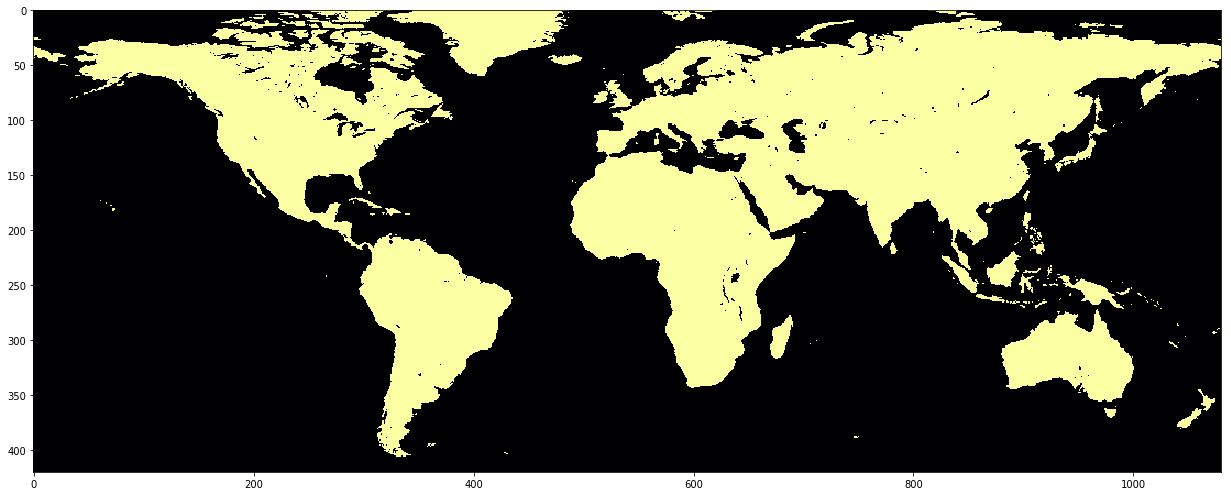

In [365]:
plot_map(open_water_array_processed)

## Mammal Diversity Map

In [366]:
mammals_raw_folder = data_raw_folder/"mammals"
mammals_processed_folder = data_processed_folder/"mammals"
mammals_raw_file = mammals_raw_folder/"all_mammals.tif"

First, we read the file with `rasterio` and immediately downscale it to the desired resolution.

In [398]:
mammals_array = array_from_tif(mammals_raw_file, longitude_size)

Then, we cut off the poles and leave the map from 60 degrees S to 80 degrees N.

In [417]:
mammals_array_processed = cut_poles(mammals_array, (-90, 90), latitude_range) * open_water_array_processed
mammals_array_processed = mammals_array_processed / mammals_array_processed.max()

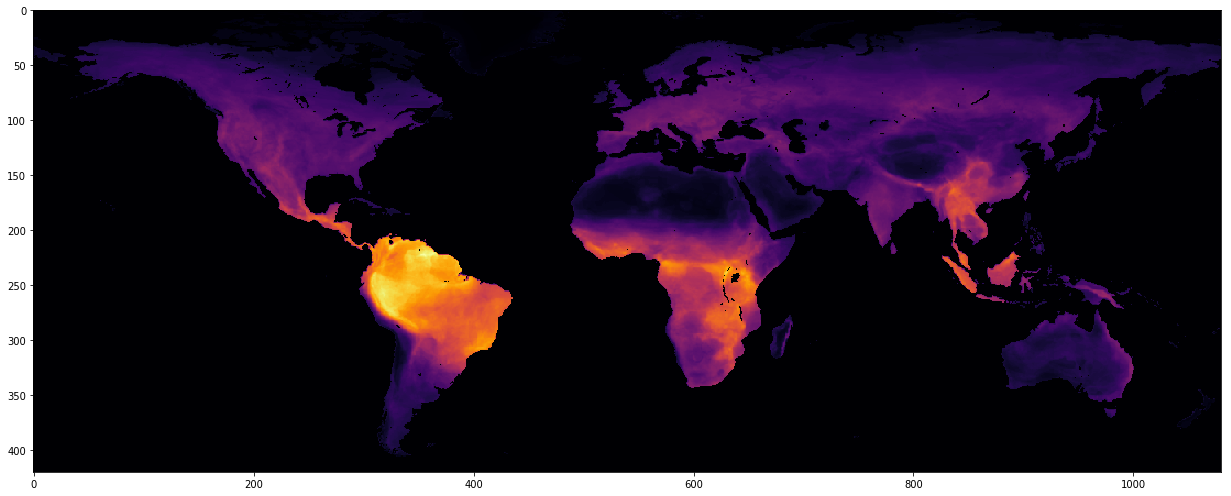

In [418]:
plot_map(mammals_array_processed)

In [514]:
save_outputs(mammals_array_processed, "mammals", mammals_processed_folder)

## Pastures

In [381]:
pastures_raw_folder = data_raw_folder/"pastures"
pastures_processed_folder = data_processed_folder/"pastures"
pastures_raw_file = pastures_raw_folder/"pasture.tif"

In [408]:
pastures_array = array_from_tif(pastures_raw_file, longitude_size)

In [409]:
pastures_array[pastures_array == pastures_array.min()] = 0

In [421]:
pastures_array_processed = cut_poles(pastures_array, (-90, 90), latitude_range) * open_water_array_processed
pastures_array_processed = pastures_array_processed / pastures_array_processed.max()

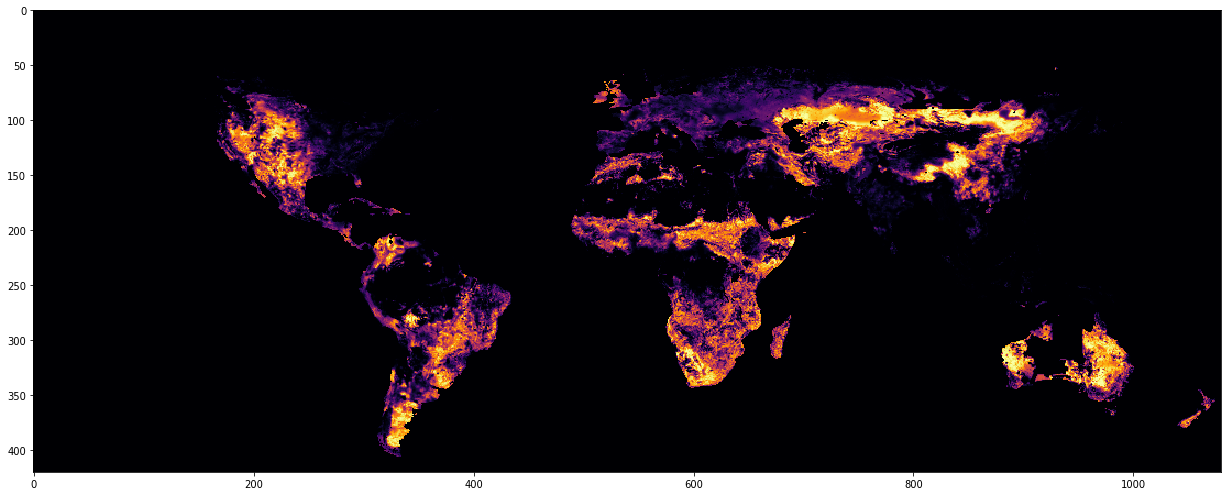

In [422]:
plot_map(pastures_array_processed)

In [516]:
save_outputs(pastures_array_processed, "pastures", pastures_processed_folder)

## Urban

In [547]:
earthenv_raw_folder = data_raw_folder/"earthenv"
urban_processed_folder = data_processed_folder/"urban"
urban_raw_file = earthenv_raw_folder/"urban.tif"

In [548]:
urban_array = array_from_tif(urban_raw_file, longitude_size)

In [549]:
urban_array_processed = cut_poles(urban_array, (-56, 90), latitude_range) * open_water_array_processed
urban_array_processed = urban_array_processed / urban_array_processed.max()

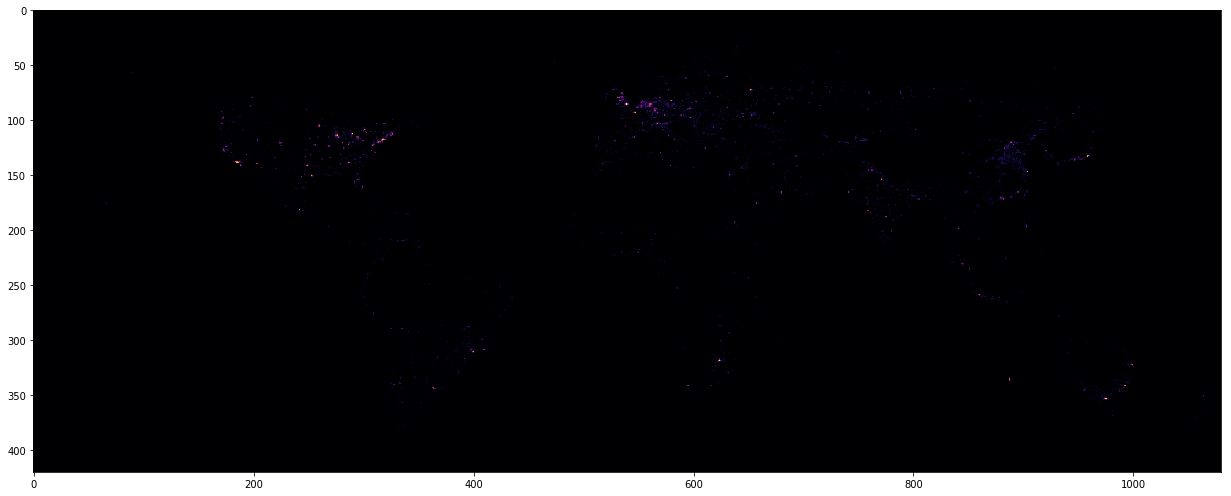

In [550]:
plot_map(urban_array_processed)

In [551]:
save_outputs(urban_array_processed, "urban", urban_processed_folder)

## Cultivated

In [542]:
earthenv_raw_folder = data_raw_folder/"earthenv"
cultivated_processed_folder = data_processed_folder/"cultivated"
cultivated_raw_file = earthenv_raw_folder/"cultivated.tif"

In [543]:
cultivated_array = array_from_tif(cultivated_raw_file, longitude_size)
cultivated_array[cultivated_array == cultivated_array.min()] = 0

In [544]:
cultivated_array_processed = cut_poles(cultivated_array, (-56, 90), latitude_range) * open_water_array_processed
cultivated_array_processed = cultivated_array_processed / cultivated_array_processed.max()

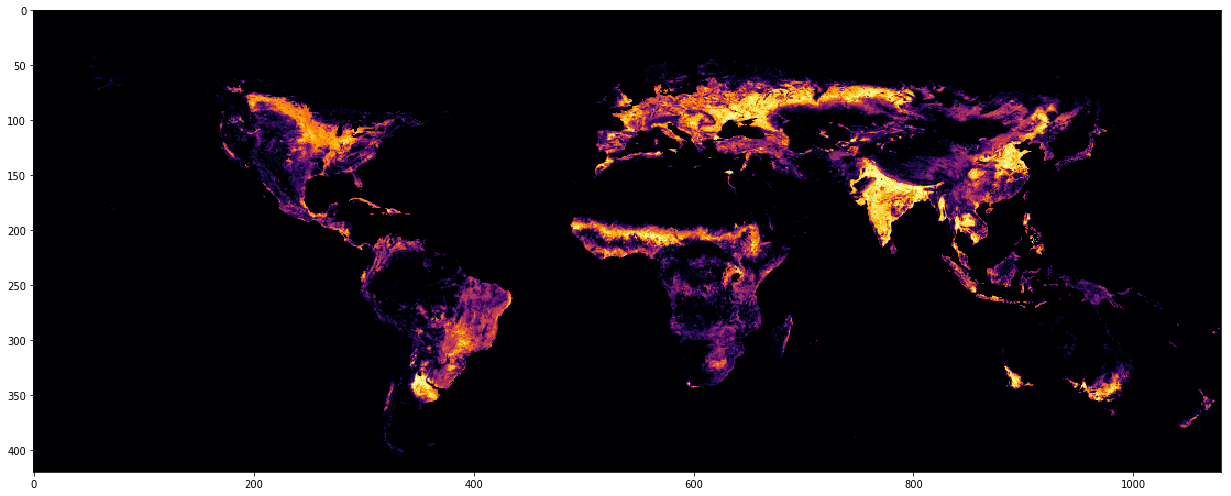

In [545]:
plot_map(cultivated_array_processed)

In [546]:
save_outputs(cultivated_array_processed, "cultivated", cultivated_processed_folder)

## Population

In [444]:
population_raw_folder = data_raw_folder/"population"
population_processed_folder = data_processed_folder/"population"
population_raw_file = population_raw_folder/"population_density_2020.tif"

In [457]:
population_array = array_from_tif(population_raw_file, longitude_size)
population_array[population_array == population_array.min()] = 0

In [472]:
population_array_processed = cut_poles(population_array, (-90, 90), latitude_range) * open_water_array_processed
population_array_processed = population_array_processed / population_array_processed.max()
population_array_processed = np.clip(population_array_processed, 0, 0.05)
population_array_processed = population_array_processed / population_array_processed.max()

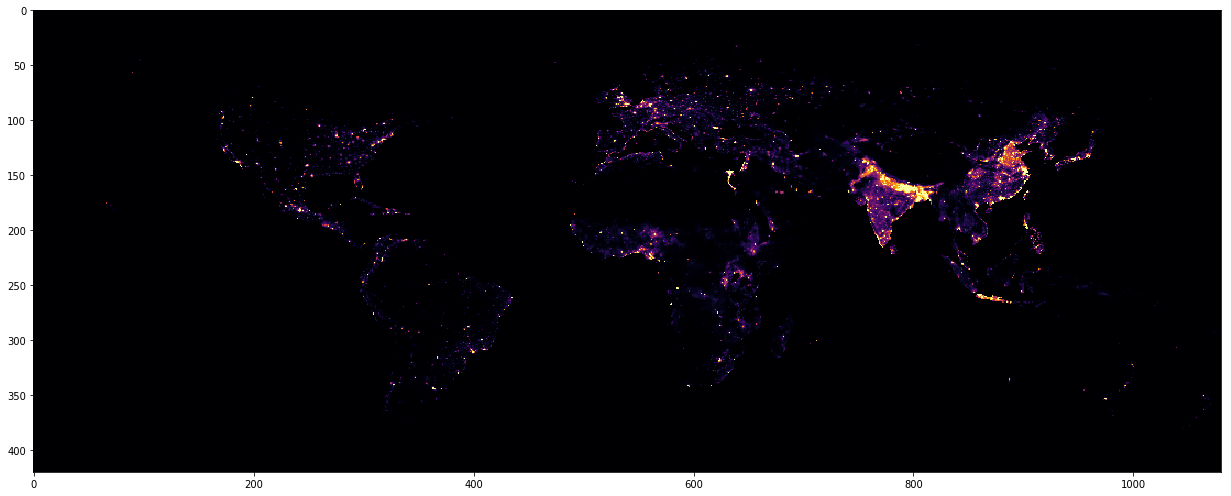

In [474]:
plot_map(population_array_processed)

In [519]:
save_outputs(population_array_processed, "population", population_processed_folder)

## Floods

In [496]:
floods_raw_folder = data_raw_folder/"floods"
floods_processed_folder = data_processed_folder/"floods"
floods_raw_file = floods_raw_folder/"gdfld.asc"

In [504]:
floods_array = array_from_tif(floods_raw_file, longitude_size)
floods_array[floods_array == floods_array.min()] = 0

In [506]:
floods_array_processed = cut_poles(floods_array, (-58, 85), latitude_range) * open_water_array_processed
floods_array_processed = floods_array_processed / floods_array_processed.max()

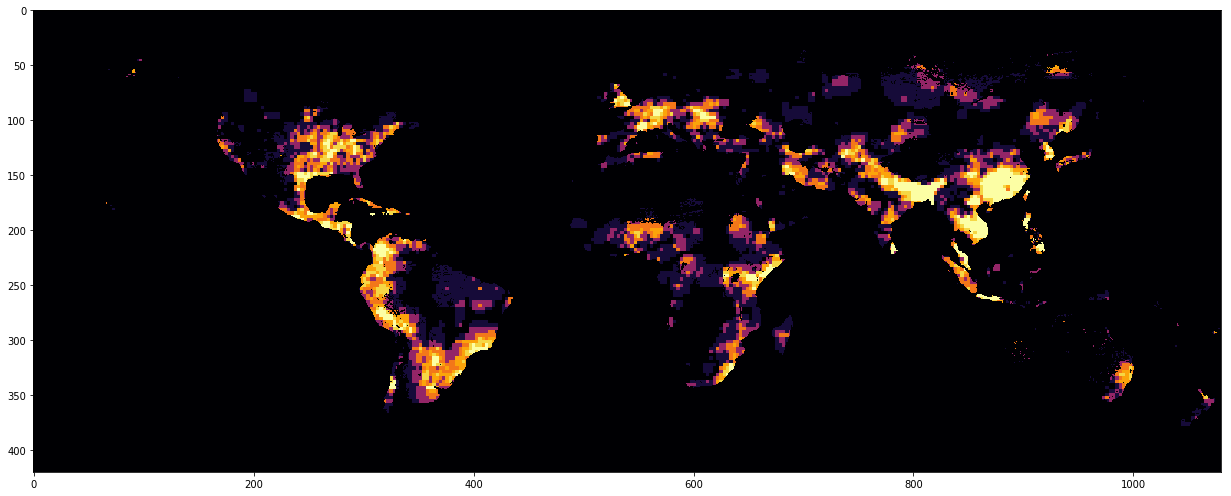

In [507]:
plot_map(floods_array_processed)

In [552]:
save_outputs(floods_array_processed, "floods", floods_processed_folder)

## Fires

In [561]:
fires_raw_folder = data_raw_folder/"fires"
fires_processed_folder = data_processed_folder/"fires"
fires_raw_file = fires_raw_folder/"fires.nc"

In [580]:
fires_array = array_from_tif(fires_raw_file, longitude_size)
fires_array = np.sum(np.clip(fires_array[:,:], 0, 20000), axis=0)
#floods_array[floods_array == floods_array.min()] = 0

In [582]:
fires_array_processed = cut_poles(fires_array, (-90, 90), latitude_range) * open_water_array_processed
fires_array_processed = fires_array_processed / fires_array_processed.max()

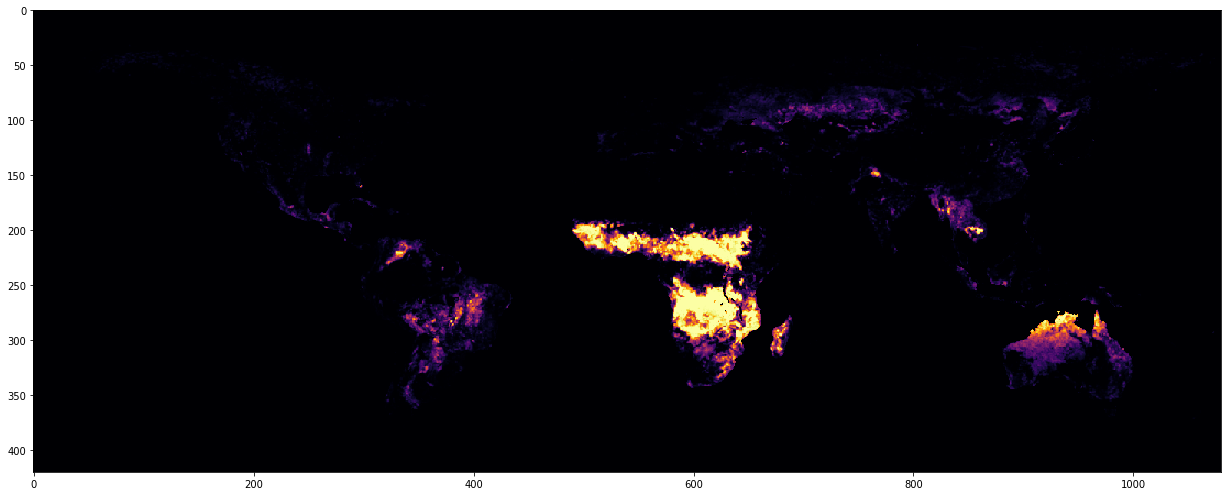

In [585]:
plot_map(fires_array_processed)

In [586]:
save_outputs(fires_array_processed, "fires", fires_processed_folder)

## Wet Markets

In [592]:
wetmarkets_raw_folder = data_raw_folder/"wetmarkets"
wetmarkets_processed_folder = data_processed_folder/"wetmarkets"
wetmarkets_raw_file = wetmarkets_raw_folder/"wetmarkets.geojson"

In [593]:
with wetmarkets_raw_file.open("r") as file:
    wetmarkets_dict = json.load(file)

In [608]:
lat_degs = latitude_range[1] - latitude_range[0]
base = np.zeros(img_common_size)
for feature in wetmarkets_dict["features"]:
    lat = feature["properties"]["Latitude"]
    lon = feature["properties"]["Longitude"]
    lat_id = int((latitude_range[1] - lat) / lat_degs * base.shape[0])
    lon_id = int((lon + 180) / 360 * base.shape[1])
    base[lat_id, lon_id] = 1
wetmarkets_array_processed = base.copy()

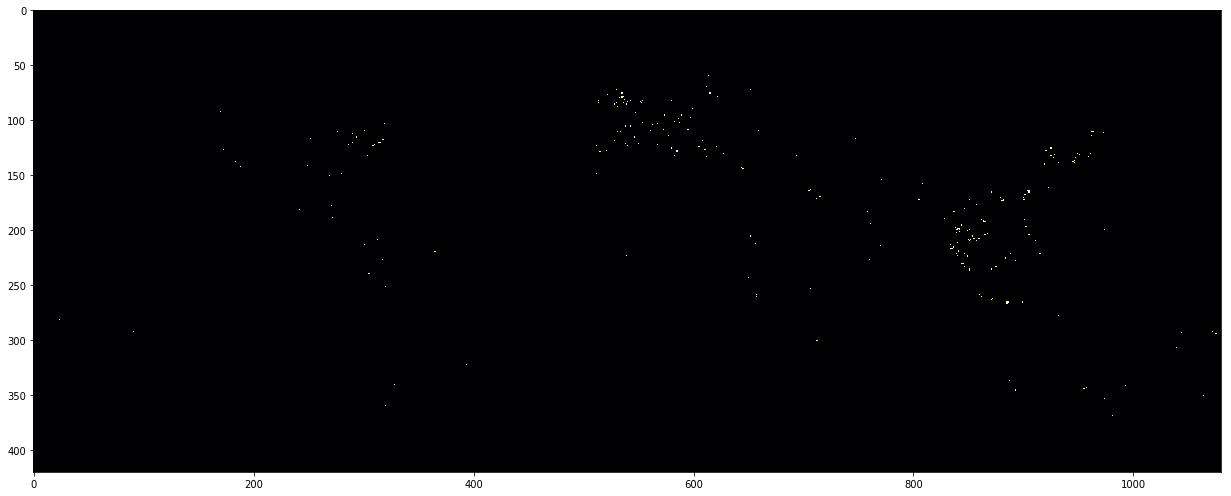

In [609]:
plot_map(wetmarkets_array_processed)

In [612]:
save_outputs(wetmarkets_array_processed, "wetmarkets", wetmarkets_processed_folder)

## GDP

In [615]:
gdp_raw_folder = data_raw_folder/"gdp"
gdp_processed_folder = data_processed_folder/"gdp"
gdp_raw_file = gdp_raw_folder/"gdp25_15mi.txt"

In [616]:
with gdp_raw_file.open("r") as file:
    gdp_lines = file.readlines()

In [654]:
gdp_data = gdp_lines[6:]
array = []
for line in gdp_data:
    values = [int(value) for value in line.split()]
    array.append(values)
gdp_array = np.array(array)

In [669]:
gdp_array_processed = zoom(gdp_array, img_common_size[1]/gdp_array.shape[1], order=1)
gdp_array_processed = np.clip(gdp_array_processed, 0, 300)
gdp_array_processed = cut_poles(gdp_array_processed, (-58, 85), latitude_range) * open_water_array_processed

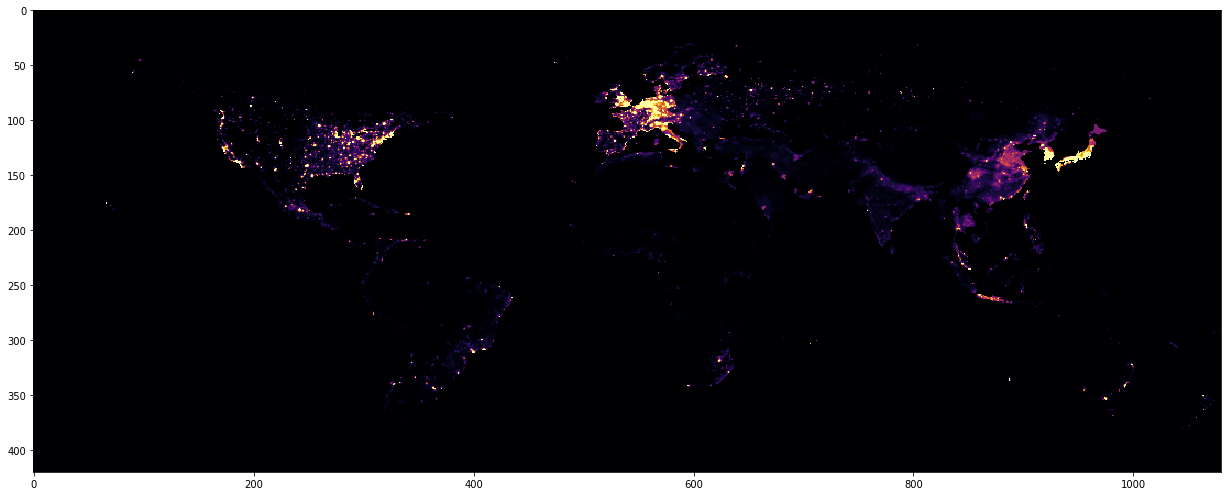

In [670]:
plot_map(gdp_array_processed)

In [672]:
save_outputs(gdp_array_processed, "wetmarkets", gdp_processed_folder)